In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = r'C:\Users\HP\Downloads\imgdataset\Multi-class Weather Dataset\train'
valid_path = r'C:\Users\HP\Downloads\imgdataset\Multi-class Weather Dataset\validation'

In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
import tensorflow
resnet152V2 =tensorflow.keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
for layer in resnet152V2.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob(r'C:\Users\HP\Downloads\imgdataset\Multi-class Weather Dataset\train\*')

In [7]:
# our layers - you can add more if you want
x = Flatten()(resnet152V2.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet152V2.input, outputs=prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(r'C:\Users\HP\Downloads\imgdataset\Multi-class Weather Dataset\train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1425 images belonging to 5 classes.


In [13]:
test_set = test_datagen.flow_from_directory(r'C:\Users\HP\Downloads\imgdataset\Multi-class Weather Dataset\validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1425 images belonging to 5 classes.


In [14]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
45/45 [==============================] - 1579s 35s/step - loss: 1.0328 - accuracy: 0.8632 - val_loss: 0.4009 - val_accuracy: 0.9523
Epoch 2/2
45/45 [==============================] - 1675s 37s/step - loss: 0.3621 - accuracy: 0.9488 - val_loss: 0.3148 - val_accuracy: 0.9663


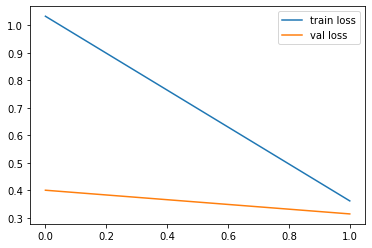

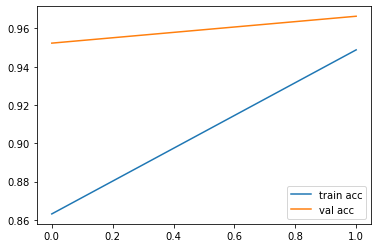

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [16]:
# save it as a h5 file
import tensorflow as tf
from tensorflow.keras.models import load_model

# save model architecture
model_json = model.to_json()
with open('resnet152v2_model.json', 'w',encoding='utf8') as json_file:
    json_file.write(model_json)

# save model's learned weights
model.save_weights('model_resnet152V2.hdf5', overwrite=True)
